# Cutting Trajectories

In [1]:
import os
os.chdir("/home/tales/dev/master/mdc_analysis/")
print("working dir", os.getcwd())

working dir /home/tales/dev/master/mdc_analysis


In [2]:
import pandas as pd
import math

from bokeh.models import PrintfTickFormatter
from bokeh.io import output_notebook, show

from src.dao import csv_dao, objects_dao
from src.plot.basic_plot import plot_result
from src.similarity.extreme_travelers import sequence_report
from src.utils.time_utils import human_time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
output_notebook()

Loading BokehJS ...

## Loading User Data

In [4]:
# users_srg = objects_dao.load_all_stop_region_group_object()
# users_tags = objects_dao.load_users_tags_sequence(sr_stay_time_above_h=0.5)["orignal"]

In [5]:
users_gps_dir = os.listdir("outputs/user_gps/")
users_gps = {}

for user_gps_dir in users_gps_dir:
    user = user_gps_dir.split("_")[0]
    users_gps[user] = csv_dao.load_user_gps_csv(user)

## Gaps

How many gaps above 06h ? <br> 
How many gaps above 12h ? <br> 
How many gaps above 24h ? <br>
How many gaps above 48h ? <br>
How much time the user has participated?

In [6]:
def gap_missing_values(report):
    t2 = report.iloc[1:len(report)]["local_time"].astype(float).reset_index(drop=True)
    t1 = report.iloc[0:len(report) - 1]["local_time"].astype(float).reset_index(drop=True)
    gaps = t2 - t1
    gaps.index = report.iloc[1:len(report)]["local_time"]
    return gaps

def gap_amount(gap, min_time_h):
    present_data_sum = gap[gap <= 60 * 60 * min_time_h].sum()
    missing_data_sum = gap[gap > 60 * 60 * min_time_h].sum()
    
    return {"missing_data_sum": missing_data_sum, "present_data_sum": present_data_sum}

def user_time_participation(report):
    first = report["local_time"].min()
    last = report["local_time"].max()
    
    n_days = (last - first) / (60*60*24)
    
    return {"n_days": n_days,
            "n_years": n_days / 365.25,
            "datetime_start": human_time(first, datetime_format='%d-%m-%Y %H:%M:%S')["datetime"],
            "datetime_end": human_time(last, datetime_format='%d-%m-%Y %H:%M:%S')["datetime"]}
    
def gaps_summary(gaps, min_time_h):
    selection = gaps[gaps > 60 * 60 * min_time_h]
    return {"n_gaps": len(selection),
            "median_sec": selection.median(),
            "min_time_gap": min_time_h}

def merge_dicts(dicts):
    final_dict = {}
    
    for d in dicts:
        
        for k in d.keys():
            final_dict[k] = d[k]

    return final_dict

def gaps_week(gaps, user_data, min_time_h):    
    gaps_df = pd.DataFrame({"gaps": gaps.tolist(), "local_time": user_data["local_time"][0:-1].tolist()})
    gaps_df["week"] = ((gaps_df["local_time"] - gaps_df["local_time"].min()) / (60*60*24*7)).apply(math.floor)
    
    return gaps_df[gaps_df["gaps"] > 60*60*min_time_h]

In [7]:
users_gaps_summary = []

for user_id in users_gps.keys():
    user_gps = users_gps[user_id]
   
    if len(user_gps) == 0:
        continue

    gaps = gap_missing_values(user_gps)
    
    user_data = {"user_id": user_id}
    user_time = user_time_participation(user_gps)
    
    for hour in [6, 12, 18, 24, 30, 36, 42, 48]:
        user_gaps_report = gaps_summary(gaps, hour)
        gap_time_sum = gap_amount(gaps, hour)
        
        users_gaps_summary.append(merge_dicts([user_data, user_time, user_gaps_report, gap_time_sum]))

users_gaps_summary = pd.DataFrame(users_gaps_summary)[["user_id", "min_time_gap", "n_gaps", "median_sec", "missing_data_sum", "present_data_sum", "datetime_end", "datetime_start", "n_years", "n_days"]]

### Counting number of gaps 
Gaps grater than 6, 12, 18, 24, 30, 36, 42 and 48 hours

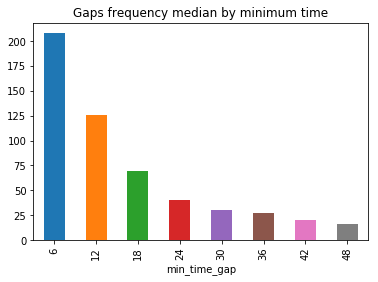

In [8]:
users_gaps_summary.groupby("min_time_gap")["n_gaps"].median().plot.bar(title="Gaps frequency median by minimum time")

### Counting frequency of gaps per day 
Gaps grater than 6, 12, 18, 24, 30, 36, 42 and 48 hours

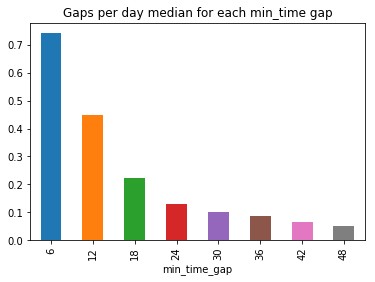

In [9]:
users_gaps_summary["gaps_per_day"] = users_gaps_summary["n_gaps"] / users_gaps_summary["n_days"]
users_gaps_summary.groupby("min_time_gap")["gaps_per_day"].median().plot.bar(title="Gaps per day median for each min_time gap")

### What is the proportion of total gaps times 
Gaps grater than 6, 12, 18, 24, 30, 36, 42 and 48 hours

In [10]:
users_gaps_summary["valid_amount_h"] = users_gaps_summary["missing_data_sum"] / (users_gaps_summary["missing_data_sum"] + users_gaps_summary["present_data_sum"])

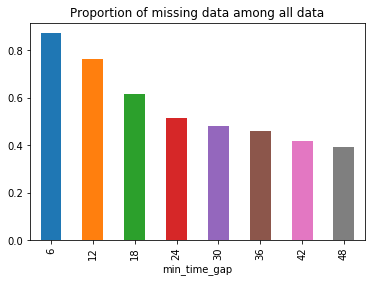

In [11]:
users_gaps_summary.groupby("min_time_gap")["valid_amount_h"].median().plot.bar(title="Proportion of missing data among all data")

# Cutting Trajectories

In [24]:
users_gaps = {}

for user_id in users_gps.keys():
    user_gps = users_gps[user_id]
   
    if len(user_gps) == 0:
        continue

    gaps = gap_missing_values(user_gps)
    
    users_gaps[user_id] = gaps

In [25]:
users_gaps

{'5448': local_time
 1256999677    2337.0
 1256999686       9.0
 1256999697      11.0
 1256999706       9.0
 1256999716      10.0
 1256999726      10.0
 1256999736      10.0
 1256999746      10.0
 1256999757      11.0
 1256999766       9.0
 1256999776      10.0
 1256999786      10.0
 1256999796      10.0
 1256999806      10.0
 1256999816      10.0
 1256999826      10.0
 1256999836      10.0
 1256999846      10.0
 1256999856      10.0
 1256999866      10.0
 1256999876      10.0
 1256999886      10.0
 1256999896      10.0
 1256999906      10.0
 1256999916      10.0
 1256999926      10.0
 1256999936      10.0
 1256999946      10.0
 1256999956      10.0
 1256999966      10.0
                ...  
 1258212125      10.0
 1258212135      10.0
 1258212145      10.0
 1258212158      13.0
 1258212165       7.0
 1258212175      10.0
 1258212185      10.0
 1258212195      10.0
 1258212205      10.0
 1258212215      10.0
 1258212225      10.0
 1258212235      10.0
 1258212245      10.0
 1258212255 